In [1]:
from qiskit import *
#IBMQ.save_account('TOKEN_AQUI')
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline

from qiskit import IBMQ, BasicAer, Aer

from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import clique
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.tools.visualization import plot_histogram
#from qiskit.aqua.components.optimizers import SPSA
#from qiskit.aqua.components.variational_forms import RY

from qiskit.tools.visualization import plot_histogram

# Using Qiskit Aqua and VQE for clique problems

This Qiskit Aqua Optimization notebook demonstrates how to use the VQE quantum algorithm to compute the clique of a given graph.

The problem is defined as follows. A clique in a graph $G$ is a complete subgraph of $G$. We'd like to find a Clique (K), defined by a variable and in a random Graph (G) with vertices (num_nodes) and the same weight_range. 

We will go through some examples to show:

1- Run using Brute-forced

2- Run the optimization using the declarative approach

3- Run the optimization using the programmatic approach

4- Run the optimization using the declarative approach with the VQE

5- Run the optimization using the programmatic approach with the VQE

6- Run the optimization using the declarative approach with the VQE with looping execution.

7- Run the optimization using the programmatic approach with the VQE with looping execution.

8- Run the optimization using the programmatic approach with the VQE in a Real Quantum Computer

Note that the solution may not be unique.

[[0. 4. 5. 0. 0.]
 [4. 0. 9. 0. 7.]
 [5. 9. 0. 0. 6.]
 [0. 0. 0. 0. 0.]
 [0. 7. 6. 0. 0.]]
{(0, 1): 4.0, (0, 2): 5.0, (1, 2): 9.0, (1, 4): 7.0, (2, 4): 6.0}


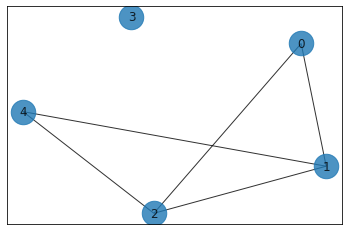

In [11]:
#Start Graph creation and Clique definition
K = 3  # K clique size
np.random.seed(100)
num_nodes = 5 # Graph vertice numbers
adjacency_matrix = clique.random_graph(num_nodes, edge_prob=0.55, weight_range=10)
#Print adjacency matrix
print(adjacency_matrix)

G = nx.from_numpy_matrix(np.array(adjacency_matrix)) 
labels = nx.get_edge_attributes(G,'weight')
#Print edges between vertices
print(labels)

pos = nx.spring_layout(G,k=10,scale=10)

#Print result graph
#nx.draw(G, pos, with_labels=True, width=2, style="solid")
#nx.draw_circular(G, with_labels=True)
nx.draw_networkx(G, with_labels=True, node_size=600, alpha = .8, pos=pos)
#nx.draw_planar(G, with_labels=True)
#nx.draw_random(G, with_labels=True)
#nx.draw_spectral(G, with_labels=True)
#nx.draw_spring(G, with_labels=True)
#nx.draw_shell(G, with_labels=True)


# 1- Run using Brute-Forced Method

Let us try a brute-force method. Basically, we exhaustively try all the binary assignments. In each binary assignment, the entry of a vertex is either 0 (meaning the vertex is not in the clique) or 1 (meaning the vertex is in the clique). We print the binary assignment that satisfies the definition of the clique (Note the size is specified as K).

Solution is  [0, 1, 1, 0, 1]  for Graph(G) with  5  vertices and a Clique(K):  3


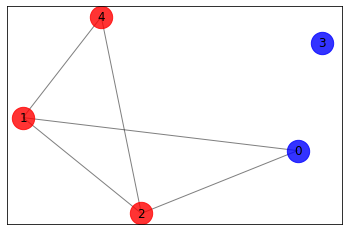

In [12]:
def brute_force():
    # brute-force way: try every possible assignment!
    def bitfield(num_nodes, L):
        result = np.binary_repr(num_nodes, L)
        return [int(digit) for digit in result]
    L = num_nodes  # length of the bitstring that represents the assignment
    max = 2**L
    has_sol = False
    for i in range(max):
        cur = bitfield(i, L)
        cur_v = clique.satisfy_or_not(np.array(cur), adjacency_matrix, K)
        #valor = 0
        #for j in range(num_nodes):
        #    valor = valor + cur[j]
        if (cur_v and np.count_nonzero(cur) == K):
            has_sol = True
            break
        else:
            has_sol = False 
    return has_sol, cur

has_sol, sol = brute_force()

if has_sol:
    print("Solution is ", sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
    #Start lists
    nol1 = []
    nol2 = []
    #Create two lists to clique vertice colors
    for w in range(num_nodes):
        if sol[w] != 0:
            nol1.append(w)
        else:
            nol2.append(w)
    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Print clique graph
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K)


# 2- Run the optimization using the declarative approach

Here the steps are:

1- Create the qubit operator i.e. Ising Hamiltonian, using clique ising translator

2- Create an EnergyInput object and a dictionary describing the algorithm and the components for Aqua to solve the problem

3- Run the algorithm and get the result

4- Use the result with the clique object to determine a solution

energy: -1501.75
clique objective: 0.0
Solution is  [1. 1. 1. 0. 0.]  for Graph(G) with  5  vertices and a Clique(K):  3


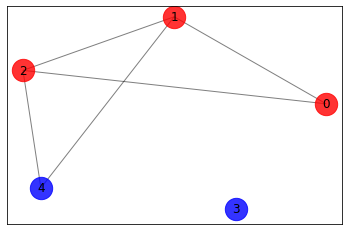

In [17]:
qubit_op, offset = clique.get_clique_qubitops(adjacency_matrix, K)

algo_input = EnergyInput(qubit_op)

params = {
    'problem': {'name': 'ising'},
    'algorithm': {'name': 'ExactEigensolver'}
}
result = run_algorithm(params, algo_input)

print('energy:', result['energy'])
#print('time:', result['eval_time'])
print('clique objective:', result['energy'] + offset)


x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
ising_sol = clique.get_graph_solution(x)

if clique.satisfy_or_not(ising_sol, adjacency_matrix, K):
    #print("Solution is", ising_sol)
    print("Solution is ", ising_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
    #Start lists
    ising_nol1 = []
    ising_nol2 = []
    #Create two lists to clique vertice colors
    for i in range(num_nodes):
        if ising_sol[i] != 0:
            ising_nol1.append(i)
        else:
            ising_nol2.append(i)

    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Imprimir o grafo com as cliques
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K)


# 3- Run the optimization using the programmatic approach

The main difference here is running the Aqua algorithm. Here we directly construct the algorithm and then run() it to get the result. The post computation on the result is identical.

energy: -1501.75
clique objective: 0.0
Solution is  [1. 1. 1. 0. 0.]  for Graph(G) with  5  vertices and a Clique(K):  3


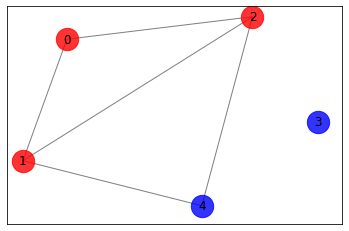

In [20]:
# We will use the qubit_op and offset from above and not re-compute them here
algo = ExactEigensolver(qubit_op)
result = algo.run()

x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
aqua_sol = clique.get_graph_solution(x)

print('energy:', result['energy'])
#print('time:', result['eval_time'])
print('clique objective:', result['energy'] + offset)

if clique.satisfy_or_not(aqua_sol, adjacency_matrix, K):
    #print("Solution is", aqua_sol)
    print("Solution is ", aqua_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
    #Start lists
    aqua_nol1 = []
    aqua_nol2 = []
    #Create two lists to clique vertice colors
    for i in range(num_nodes):
        if aqua_sol[i] != 0:
            aqua_nol1.append(i)
        else:
            aqua_nol2.append(i)

    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=aqua_nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=aqua_nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Imprimir o grafo com as cliques
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K)

# 4- Run the optimization using the declarative approach with the VQE.

We reuse the EnergyInput object we created above. VQE algorithm needs an optimizer and a variational form. Then also we need a quantum backend on which the algorithm will run.

Adjacency Matrix: [[0. 4. 5. 0. 0.]
 [4. 0. 9. 0. 7.]
 [5. 9. 0. 0. 6.]
 [0. 0. 0. 0. 0.]
 [0. 7. 6. 0. 0.]]
energy: -1496.787109375
time: 43.710407972335815
clique objective: 4.962890625
No solution found for K= 3  para os valores:  [1. 0. 1. 0. 1.]  Follow generated Graph: 


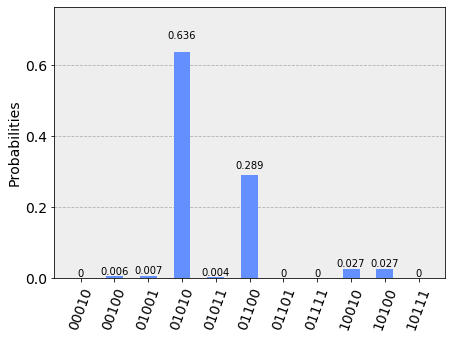

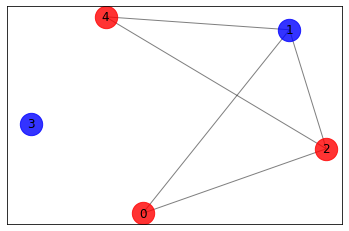

In [26]:
#VQE Declarative without Looping
#qubit_op, offset = clique.get_clique_qubitops(adjacency_matrix, K)
#algo_input = EnergyInput(qubit_op)

params = {
    'problem': {'name': 'ising'},
    'algorithm': {'name': 'VQE'},
    'optimizer': {'name': 'COBYLA', 'maxiter': 250},
    'variational_form': {'name': 'RY', 'depth': 5, 'entanglement': 'linear'}
}

backend = Aer.get_backend ('qasm_simulator') #('statevector_simulator')
print("Adjacency Matrix:", adjacency_matrix)

result = run_algorithm(params, algo_input, backend=backend)
x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
ising_vqed_sol = clique.get_graph_solution(x)
getclique = clique.satisfy_or_not(ising_vqed_sol, adjacency_matrix, K)

print('energy:', result['energy'])
print('time:', result['eval_time'])
print('clique objective:', result['energy'] + offset)


if getclique:
    print("Solution is ", ising_vqed_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
else:
    print("No solution found for K=", K, " para os valores: ", ising_vqed_sol, " Follow generated Graph: ")    
    
#Start lists
ising_vqed_nol1 = []
ising_vqed_nol2 = []
#Create two lists to clique vertice colors
for i in range(num_nodes):
    if ising_vqed_sol[i] != 0:
        ising_vqed_nol1.append(i)
    else:
        ising_vqed_nol2.append(i)

pos=nx.spring_layout(G,k=10,scale=10)
#Red color for clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqed_nol1,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
#Blue color for not clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqed_nol2,
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
#Imprimir o grafo com as cliques
nx.draw_networkx_labels(G,pos,with_labels=True)
#else:
#    print("No solution found for K=", K, " para os valores: ", ising_vqed_sol)

counts = result['min_vector']
#print (counts)
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

# 5- Run the optimization using the programmatic approach with the VQE.

We can create the objects directly ourselves too and run VQE for the result

Adjacency Matrix: [[0. 4. 5. 0. 0.]
 [4. 0. 9. 0. 7.]
 [5. 9. 0. 0. 6.]
 [0. 0. 0. 0. 0.]
 [0. 7. 6. 0. 0.]]
energy: -1340.35
time: 43.398656606674194
clique objective: 161.4000000000001
optimal_cost: -1340.35
No solution found for K= 3  para os valores:  [1. 0. 1. 0. 1.]  Follow generated Graph: 


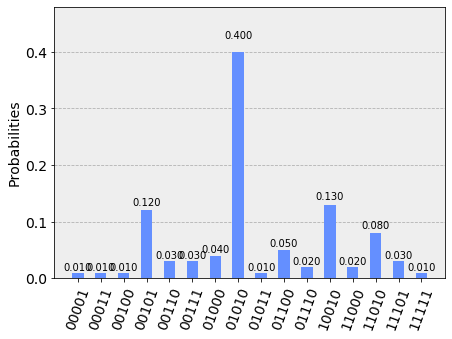

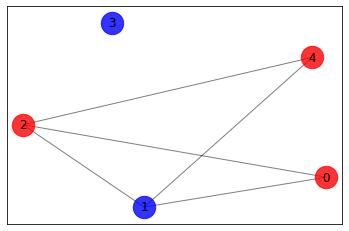

In [27]:
# VQE Programmatic without looping
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

#aqua_globals.random_seed = 10598
#seed = 10598
optimizer = COBYLA(maxiter=250)
#optimizer = SPSA(max_trials=200)
var_form = RY(qubit_op.num_qubits, depth=5, entanglement='linear')
vqe_clique = VQE(qubit_op, var_form, optimizer)
#backend = BasicAer.get_backend('statevector_simulator')
#quantum_instance = QuantumInstance(backend=backend, shots=1) #, seed_simulator=seed)
#result = vqe_clique.run(quantum_instance)

backend = Aer.get_backend('qasm_simulator') #('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=100) #, seed_simulator=seed)
result = vqe_clique.run(quantum_instance)

print("Adjacency Matrix:", adjacency_matrix)
x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
ising_vqep_sol = clique.get_graph_solution(x)
getclique = clique.satisfy_or_not(ising_vqep_sol, adjacency_matrix, K)

print('energy:', result['energy'])
print('time:', result['eval_time'])
print('clique objective:', result['energy'] + offset)
print('optimal_cost:', vqe_clique.get_optimal_cost())
#print(result)
counts = result['min_vector']
plot_histogram(counts)


if getclique:
    print("Solution is ", ising_vqep_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
else:
    print("No solution found for K=", K, " para os valores: ", ising_vqep_sol, " Follow generated Graph: ")

#Start lists
ising_vqep_nol1 = []
ising_vqep_nol2 = []
#Create two lists to clique vertice colors
for i in range(num_nodes):
    if ising_vqep_sol[i] != 0:
        ising_vqep_nol1.append(i)
    else:
        ising_vqep_nol2.append(i)

pos=nx.spring_layout(G,k=10,scale=10)
#Red color for clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqep_nol1,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
#Blue color for not clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqep_nol2,
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
#Imprimir o grafo com as cliques
nx.draw_networkx_labels(G,pos,with_labels=True)
#else:
#    print("No solution found for K=", K, " para os valores: ", ising_vqep_sol)

counts = result['min_vector']
#print (counts)
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

# 6- Run the optimization using the declarative approach with the VQE with looping execution.

In this case, we will use declarative approach with VQE and we will execute looping process until find the rigth solution on VQE. This method will show us how many times will be necessary to get the result for our problem

Adjacency Matrix: [[0. 4. 5. 0. 0.]
 [4. 0. 9. 0. 7.]
 [5. 9. 0. 0. 6.]
 [0. 0. 0. 0. 0.]
 [0. 7. 6. 0. 0.]]
Clique(K): 3
Execution: 1
ISING: [1. 0. 1. 0. 1.]
Execution  1 time: 27.955482244491577
Execution: 2
ISING: [1. 0. 1. 1. 0.]
Execution  2 time: 29.912362813949585
Execution: 3
ISING: [1. 0. 1. 1. 0.]
Execution  3 time: 28.727060317993164
Execution: 4
ISING: [1. 1. 1. 0. 0.]
Execution  4 time: 27.39345669746399
energy: -1490.4318539001144
time: 113.98836207389832
Total Executions: 4
clique objective: 11.318146099885553
Solution is  [1. 1. 1. 0. 0.]  for Graph(G) with  5  vertices and a Clique(K):  3


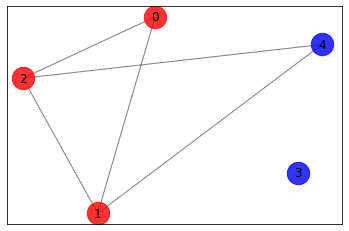

In [22]:
# VQE Declarative with looping
params = {
    'problem': {'name': 'ising'}, #'random_seed': 10598},
    'algorithm': {'name': 'VQE'},
    'optimizer': {'name': 'COBYLA','maxiter': 250},
    'variational_form': {'name': 'RY', 'depth': 5, 'entanglement': 'linear'}
}
backend = Aer.get_backend('statevector_simulator')
contExec=0
print("Adjacency Matrix:", adjacency_matrix)
print("Clique(K):", K)

getclique=False
totaltime=0

while not getclique:
    contExec= contExec+1
    print ("Execution:", contExec)
    result = run_algorithm(params, algo_input, backend=backend)
    x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
    ising_vqed_sol = clique.get_graph_solution(x)
    print("ISING:", ising_vqed_sol)
    getclique = clique.satisfy_or_not(ising_vqed_sol, adjacency_matrix, K)
    if np.count_nonzero(ising_vqed_sol) != K:
        getclique = False
    totaltime=totaltime+result['eval_time']
    print("Execution ", contExec, "time:",  result['eval_time'])

print('energy:', result['energy'])
print('time:', totaltime)
print('Total Executions:', contExec)
print('clique objective:', result['energy'] + offset)
#print('solution:', clique.get_graph_solution(x))

if getclique:
    print("Solution is ", ising_vqed_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
    #Start lists
    ising_vqed_nol1 = []
    ising_vqed_nol2 = []
    #Create two lists to clique vertice colors
    for i in range(num_nodes):
        if ising_vqed_sol[i] != 0:
            ising_vqed_nol1.append(i)
        else:
            ising_vqed_nol2.append(i)

    pos=nx.spring_layout(G,k=10,scale=10)
    #Red color for clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_vqed_nol1,
                           node_color='r',
                           node_size=500,
                       alpha=0.8)
    #Blue color for not clique vertices
    nx.draw_networkx_nodes(G,pos,
                           nodelist=ising_vqed_nol2,
                           node_color='b',
                           node_size=500,
                       alpha=0.8)

    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    #Imprimir o grafo com as cliques
    nx.draw_networkx_labels(G,pos,with_labels=True)
else:
    print("No solution found for K=", K)


# 7- Run the optimization using the programmatic approach with the VQE with looping execution

In this case, we will use programmatic approach with VQE and we will execute looping process until find the rigth solution on VQE. This method will show us how many times will be necessary to get the result for our problem


Adjacency Matrix: [[0. 4. 5. 0. 0.]
 [4. 0. 9. 0. 7.]
 [5. 9. 0. 0. 6.]
 [0. 0. 0. 0. 0.]
 [0. 7. 6. 0. 0.]]
Clique(K): 3
Execution: 1
ISING: [1. 0. 1. 1. 0.]
Execution  1 time: 26.682563543319702
Execution: 2
ISING: [1. 0. 1. 1. 0.]
Execution  2 time: 25.509300231933594
Execution: 3
ISING: [0. 1. 0. 1. 1.]
Execution  3 time: 25.94608998298645
Execution: 4
ISING: [1. 1. 0. 1. 0.]
Execution  4 time: 25.57047390937805
Execution: 5
ISING: [1. 0. 1. 0. 1.]
Execution  5 time: 25.630426168441772
Execution: 6
ISING: [1. 0. 1. 0. 1.]
Execution  6 time: 25.762109518051147
Execution: 7
ISING: [0. 0. 1. 1. 1.]
Execution  7 time: 25.435407400131226
Execution: 8
ISING: [0. 1. 0. 1. 1.]
Execution  8 time: 25.29928731918335
Execution: 9
ISING: [1. 0. 1. 1. 0.]
Execution  9 time: 26.322052478790283
Execution: 10
ISING: [1. 0. 1. 0. 1.]
Execution  10 time: 25.540714263916016
Execution: 11
ISING: [1. 1. 0. 0. 1.]
Execution  11 time: 26.398114681243896
Execution: 12
ISING: [1. 0. 1. 0. 1.]
Execution  12 

{0: Text(-8.998957235967852, 3.367164501121871, '0'),
 1: Text(-0.027728045733875554, 10.0, '1'),
 2: Text(8.398174118807038, 2.7934098863455006, '2'),
 3: Text(-5.910265725910431, -7.5518217297429, '3'),
 4: Text(6.538776888805119, -8.608752657724471, '4')}

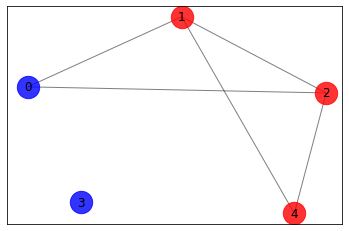

In [21]:
#VQE Programmatic with looping
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA #SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

#qubit_op, offset = clique.get_clique_qubitops(adjacency_matrix, K)
#algo_input = EnergyInput(qubit_op)
#aqua_globals.random_seed = 10598
#seed = 10598
optimizer = COBYLA(maxiter=250)
#optimizer = SPSA(max_trials=200)
var_form = RY(qubit_op.num_qubits, depth=5, entanglement='linear')
vqe_clique = VQE(qubit_op, var_form, optimizer)
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=100) #, seed_simulator=seed)

#result = vqe_clique.run(backend)

contExec=0
print("Adjacency Matrix:", adjacency_matrix)
print("Clique(K):", K)

getclique=False
totaltime=0

while not getclique:
    contExec= contExec+1
    print ("Execution:", contExec)
    result = vqe_clique.run(quantum_instance)
    x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
    ising_vqep_sol = clique.get_graph_solution(x)
    print("ISING:", ising_vqep_sol)
    getclique = clique.satisfy_or_not(ising_vqep_sol, adjacency_matrix, K)
    if np.count_nonzero(ising_vqep_sol) != K:
        getclique = False
    totaltime=totaltime+result['eval_time']
    print("Execution ", contExec, "time:",  result['eval_time'])
    #print("Get_Result: ", clique.get_gset_result(x))

print('energy:', result['energy'])
print('time:', totaltime)
print('Total Executions:', contExec)
print('clique objective:', result['energy'] + offset)
print('optimal_cost:', vqe_clique.get_optimal_cost())
#print("VQE_ISING:", ising_vqep_sol)
#print('solution:', clique.get_graph_solution(x))

if getclique:
    print("Solution is ", ising_vqep_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
else:
    print("No solution found for K=", K, " para os valores: ", ising_vqep_sol, " Follow generated Graph: ")

#Start lists
ising_vqep_nol1 = []
ising_vqep_nol2 = []
#Create two lists to clique vertice colors
for i in range(num_nodes):
    if ising_vqep_sol[i] != 0:
        ising_vqep_nol1.append(i)
    else:
        ising_vqep_nol2.append(i)

pos=nx.spring_layout(G,k=10,scale=10)
#Red color for clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqep_nol1,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
#Blue color for not clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqep_nol2,
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
#Imprimir o grafo com as cliques
nx.draw_networkx_labels(G,pos,with_labels=True)

# 8- Run the optimization using the programmatic approach with the VQE without looping and using Real Quantum Computing

In [ ]:
# VQE Programmatic without looping
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA #SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.providers.ibmq import least_busy

large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits  >= num_nodes and
                                                      not x.configuration().simulator and
                                                      x.status().operational==True)
backend = least_busy(large_enough_devices)
if large_enough_devices != []:
    backend = least_busy(large_enough_devices)
    print("The best backend is " + backend.name())
else:
    print("No device available for input parameters")

#qubit_op, offset = clique.get_clique_qubitops(adjacency_matrix, K)
#algo_input = EnergyInput(qubit_op)
#aqua_globals.random_seed = 10598
#seed = 10598
optimizer = COBYLA(maxiter=250)
#optimizer = SPSA(max_trials=200)
var_form = RY(qubit_op.num_qubits, depth=5, entanglement='linear')
vqe_clique = VQE(qubit_op, var_form, optimizer, 'paulis')

#IBMQ.load_account() #ativa a conta da IBM
#provider = IBMQ.get_provider('ibm-q') #cria um provider
#qcomp = provider.get_backend(backend) #aponta para o computador real desejado
quantum_instance = QuantumInstance(backend=backend, shots=100) #, seed_simulator=seed)
result = vqe_clique.run(quantum_instance)
#job = execute (vqe_clique, backend=qcomp) #executa o job
#job_monitor(job) #monitora a execução do job
#result = job.result() #joga o resultado para uma variável

print("Adjacency Matrix:", adjacency_matrix)
x = clique.sample_most_likely(len(adjacency_matrix), result['eigvecs'][0])
ising_vqep_sol = clique.get_graph_solution(x)
getclique = clique.satisfy_or_not(ising_vqep_sol, adjacency_matrix, K)

print('energy:', result['energy'])
print('time:', result['eval_time'])
print('clique objective:', result['energy'] + offset)
print('optimal_cost:', vqe_clique.get_optimal_cost())

if getclique:
    print("Solution is ", ising_vqep_sol, " for Graph(G) with ", num_nodes, " vertices and a Clique(K): ", K)
else:
    print("No solution found for K=", K, " para os valores: ", ising_vqep_sol, " Follow generated Graph: ")

#Start lists
ising_vqep_nol1 = []
ising_vqep_nol2 = []
#Create two lists to clique vertice colors
for i in range(num_nodes):
    if ising_vqep_sol[i] != 0:
        ising_vqep_nol1.append(i)
    else:
        ising_vqep_nol2.append(i)

pos=nx.spring_layout(G,k=10,scale=10)
#Red color for clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqep_nol1,
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
#Blue color for not clique vertices
nx.draw_networkx_nodes(G,pos,
                       nodelist=ising_vqep_nol2,
                       node_color='b',
                       node_size=500,
                   alpha=0.8)

nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
#Imprimir o grafo com as cliques
nx.draw_networkx_labels(G,pos,with_labels=True)
#else:
#    print("No solution found for K=", K, " para os valores: ", ising_vqep_sol)


C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:548: DeprecationWarning: IBMQ.backends() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.backends() to find its backends.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\aqua\algorithms\adaptive\vqe\vqe.py:105: DeprecationWarning: operator_mode option is deprecated and it will be removed after 0.6. Now the operator has its own mode, no need extra info to tell the VQE.
  "Now the operator has its own mode, no need extra info to tell the VQE.", DeprecationWarning)
The skip Qobj validation does not work for IBMQ provider. Disable it.


The best backend is ibmq_burlington


# Show circuit execution draw

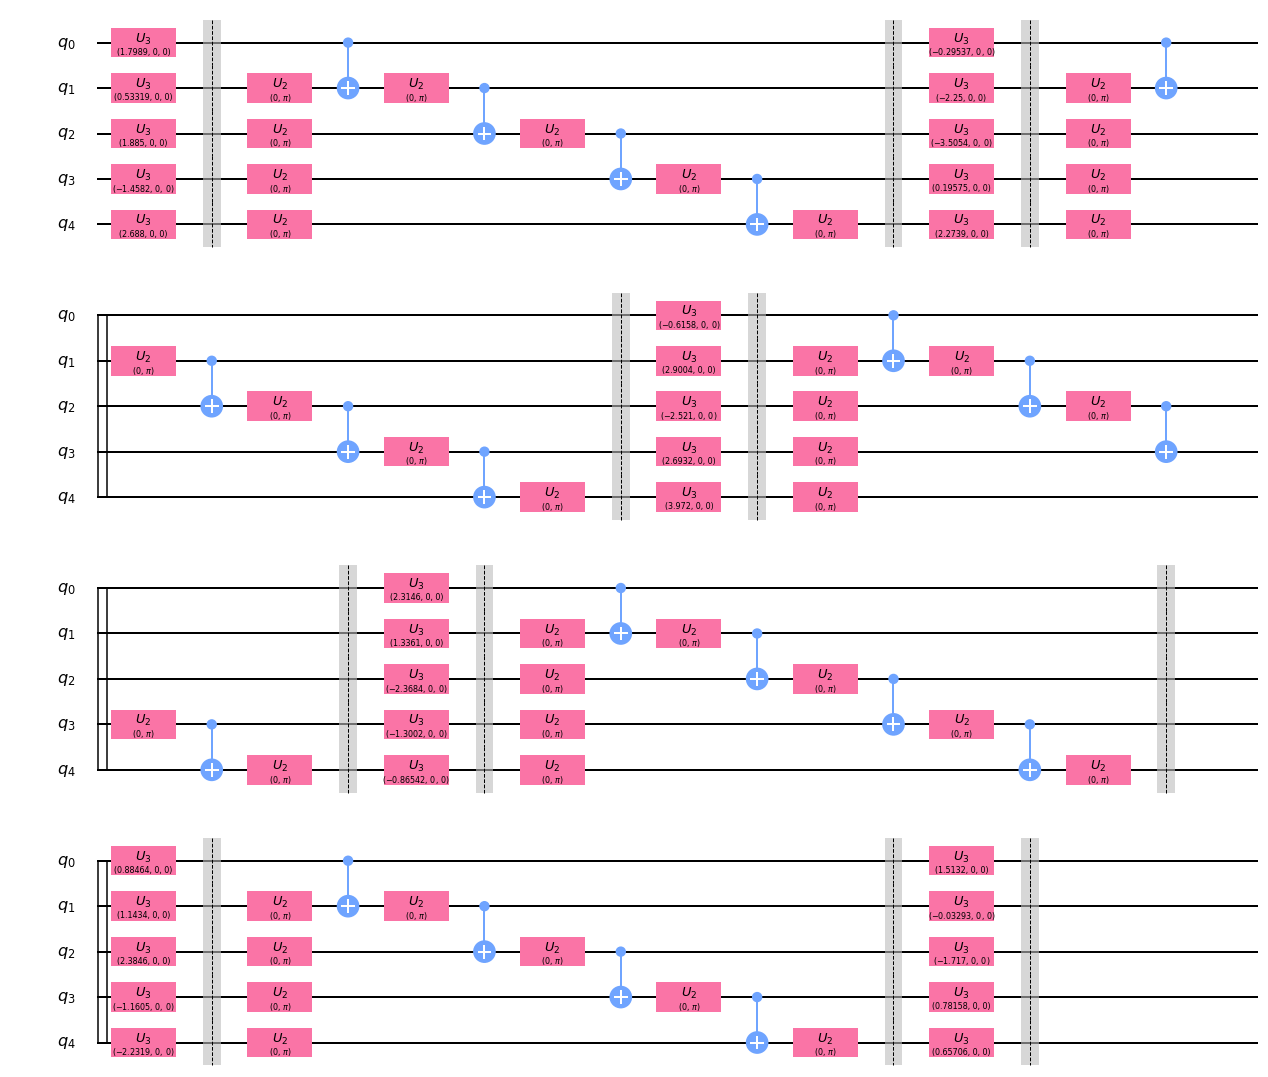

In [26]:
from qiskit.tools.visualization import circuit_drawer

#vqe_clique.print_settings()
#vqe_clique.construct_circuit(parameter=np.array(adjacency_matrix),backend=backend)
#,use_simulator_operator_mode=False, statevector_mode=None, circuit_name_prefix='')

#circuit_drawer(vqe_clique.get_optimal_circuit())

vqe_clique.get_optimal_circuit().draw(output='mpl')


#vqe_clique.get_optimal_vector()
#plot_histogram(counts)


# Show vector result

In [27]:
vqe_clique.get_optimal_vector()

array([-3.62331534e-05+0.j,  4.06820209e-03+0.j, -1.54525162e-03+0.j,
       -1.08073523e-05+0.j,  4.71440785e-03+0.j, -2.53388082e-03+0.j,
        8.77876680e-03+0.j, -1.22908644e-02+0.j,  4.49548640e-03+0.j,
        8.80117154e-01+0.j, -3.39258979e-01+0.j,  1.04386693e-03+0.j,
        1.37534529e-03+0.j, -1.85908595e-03+0.j, -1.51986102e-03+0.j,
       -3.58792550e-03+0.j,  1.60429439e-03+0.j,  3.09243311e-01+0.j,
       -1.19212965e-01+0.j,  3.76097315e-04+0.j, -3.22453295e-03+0.j,
        2.06694594e-03+0.j, -2.50858657e-03+0.j,  8.40030033e-03+0.j,
        6.37387802e-05+0.j,  2.93316727e-03+0.j, -1.14404327e-03+0.j,
        8.15917362e-06+0.j,  1.67593120e-03+0.j, -9.06069670e-04+0.j,
        3.09109115e-03+0.j, -4.36937934e-03+0.j])

In [ ]:
#Check IBM servers available
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
#Check IBM Servers queue and status
for backend in provider.backends():
    print( backend.status() )